# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra


from phydra.utility.xsimlabwrappers import phydra_setup

In [3]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import BaseEnvironment, Slab
from phydra.processes.fluxes import Flux, LimitedGrowth
from phydra.processes.forcingfluxes import Mixing, Sinking, Upwelling, make_FX_flux
from phydra.processes.forcing import SinusoidalMLD, ConstantN0
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [4]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [5]:
print(dir())

['BaseEnvironment', 'Boundary0D', 'Component', 'ConstantN0', 'Flux', 'GekkoContext', 'GekkoSolve', 'Grid0D', 'In', 'InheritGekkoContext', 'LimitedGrowth', 'MLDForcing', 'Mixing', 'NutrientForcing', 'Out', 'Sinking', 'SinusoidalMLD', 'Slab', 'Time', 'Upwelling', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_i4', '_i5', '_ih', '_ii', '_iii', '_oh', 'exit', 'get_ipython', 'inspect', 'make_Component', 'make_FX_flux', 'np', 'os', 'phydra', 'phydra_setup', 'quit', 'sys', 'xs']


In [6]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.66.g93bbb78.dirty


In [7]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), 'D':make_Component('Detritus','D'),
    'Env':Slab, 
    
    # Fluxes
    'P_Growth':LimitedGrowth, 
    
    # ForcingFluxes
    'Sinking':make_FX_flux(Sinking, 'S'),
    'Upwelling':make_FX_flux(Upwelling, 'U'),

    
    'MLD':SinusoidalMLD, 
    'N0':ConstantN0, 
    
    'solver':GekkoSolve
})

model

<class 'phydra.processes.forcingfluxes.Sinking'> S
<class 'phydra.processes.forcingfluxes.S'>
<class 'phydra.processes.forcingfluxes.Upwelling'> U
<class 'phydra.processes.forcingfluxes.U'>


<xsimlab.Model (15 processes, 25 inputs)>
context
time
    days            [in] ('time',) time in days
grid
    length          [in]
    shape           [in]
ibcs
    ibc             [in] Initial Boundary Conditions
N
    init            [in]
    label           [in]
    dim             [in]
P
    dim             [in]
    init            [in]
    label           [in]
Z
    dim             [in]
    init            [in]
    label           [in]
D
    label           [in]
    init            [in]
    dim             [in]
N0
    constant_N0     [in] value of the constant Nutrient forcing
MLD
Env
P_Growth
    mu              [in] Maximum growth rate of component
    C_label         [in] label of component that grows
    R_label         [in] label of ressource component that is consumed
    halfsat         [in] half-saturation constant of nutrient uptak...
Sinking
    kappa           [in] constant mixing coefficient
    C_labels        [in] S label of component(s) that grows
Upwelling
    ka

In [8]:
model.index_vars 

[('time', 'time'),
 ('N', 'index'),
 ('P', 'index'),
 ('Z', 'index'),
 ('D', 'index'),
 ('Env', 'components')]

In [9]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365*3)),
        
        'N':{'dim':1,'label':'N','init':1}, 
        'P':{'dim':1,'label':'P','init':1},
        'Z':{'dim':1,'label':'Z','init':1},
        'D':{'dim':1,'label':'D','init':1},
        
        'P_Growth':{'mu':0.1,
               'C_label':'P',
               'R_label':'N',
               'halfsat':0.5},
        
        'Sinking':{'kappa':0.1,
               'C_labels':['D','P']},
        
        'Upwelling':{'kappa':0.1,
               'C_labels':['N']},
        
        'N0__constant_N0':2.
    },
    output_vars={
        'Env__outputs':None
    }
                 )

In [10]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
Initializing component  N
['N']
GKFLUXES SVFluxes dict stores: dict_items([])
Initializing component  P
['P']
GKFLUXES SVFluxes dict stores: dict_items([])
Initializing component  Z
['Z']
GKFLUXES SVFluxes dict stores: dict_items([])
Initializing component  D
['D']
GKFLUXES SVFluxes dict stores: dict_items([])
initializing forcing base now
initializing forcing base now
Initialize NutrientDependency
Growth Dependency_component: P []
DICTITEMS N i2 defaultdict(<class 'list'>, {'P': [], 'N': [0]})
DICTITEMS P i3 defaultdict(<class 'list'>, {'P': [0], 'N': [0]})
GK flux SVFluxes dict stores: dict_items([('P', [0]), ('N', [0])])
D <class 'numpy.ndarray'>


TypeError: unhashable type: 'numpy.ndarray'

In [17]:
out_ds

<xarray.Dataset>
Dimensions:                (N: 1, clock: 2, components: 4, time: 1095)
Coordinates:
  * clock                  (clock) int64 0 1
  * components             (components) <U1 'N' 'P' 'Z' 'D'
  * time                   (time) int64 0 1 2 3 4 5 ... 1090 1091 1092 1093 1094
Dimensions without coordinates: N
Data variables:
    AllComps__outputs      (components, time) float64 1.0 0.9396 ... 1.0 1.0
    D__dim                 int64 1
    D__init                int64 1
    D__label               <U1 'D'
    N_Mixing__C_label      <U1 'N'
    N_Mixing__N0_constant  int64 2
    N_Mixing__kappa        float64 0.1
    N__dim                 int64 1
    N__init                int64 1
    N__label               <U1 'N'
    P_Growth__C_label      <U1 'P'
    P_Growth__R_label      <U1 'N'
    P_Growth__halfsat      float64 0.5
    P_Growth__mu           float64 0.1
    P_Sinking__C_label     <U1 'P'
    P_Sinking__kappa       float64 0.1
    P__dim                 int64 1
    P__init                int64 1
    P__label               <U1 'P'
    Z__dim                 int64 1
    Z__init                int64 1
    Z__label               <U1 'Z'
    grid__length           int64 1
    grid__shape            int64 1
    ibcs__ibc              float64 nan
    index                  (N) <U1 'D'
    time__days             (time) int64 0 1 2 3 4 5 ... 1090 1091 1092 1093 1094

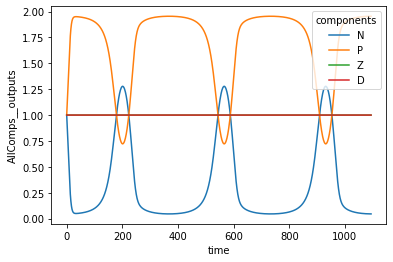

In [18]:
out_ds.AllComps__outputs.set_index(time='time',).plot.line(x='time')